## Feature extraction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import afdetection.utils.paths as path
from afdetection.data.make_dataset import MakeDataset
from afdetection.data.signal_preprocessing import SignalPreprocessing
from afdetection.features.build_features import BuildFeatures

sns.set_theme()

## Preprocessing

In [3]:
# Leads names
leads = [
    'I',
    'II', 
    'III', 
    'aVF', 
    'aVR', 
    'aVL', 
    'V1', 
    'V2', 
    'V3', 
    'V4', 
    'V5', 
    'V6', 
]

fs = 500 # Sampling frequency

# Intantiate objects
make_data = MakeDataset()
preprocessing = SignalPreprocessing()

# Load ECGs
ecg_data_DIR = path.data_raw_dir('ecgeq-500hzsrfava.npy')
ecg = make_data.read_from_np(ecg_data_DIR)

# # Mean removal
# ecg = preprocessing.mean_removal(ecg)

# Wander removal
ecg = preprocessing.wander_removal(ecg, fs)

# Pan–Tompkins algorithm
w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg = preprocessing.pan_tompkins(ecg, fs, w)

# Remove first and last second of the ECGs
ecg = ecg[:, 1*fs:-1*fs, :]
m, n, lead = ecg.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

# Mean removal
ecg = preprocessing.mean_removal(ecg)

# Normalize
ecg = preprocessing.normalize(ecg)

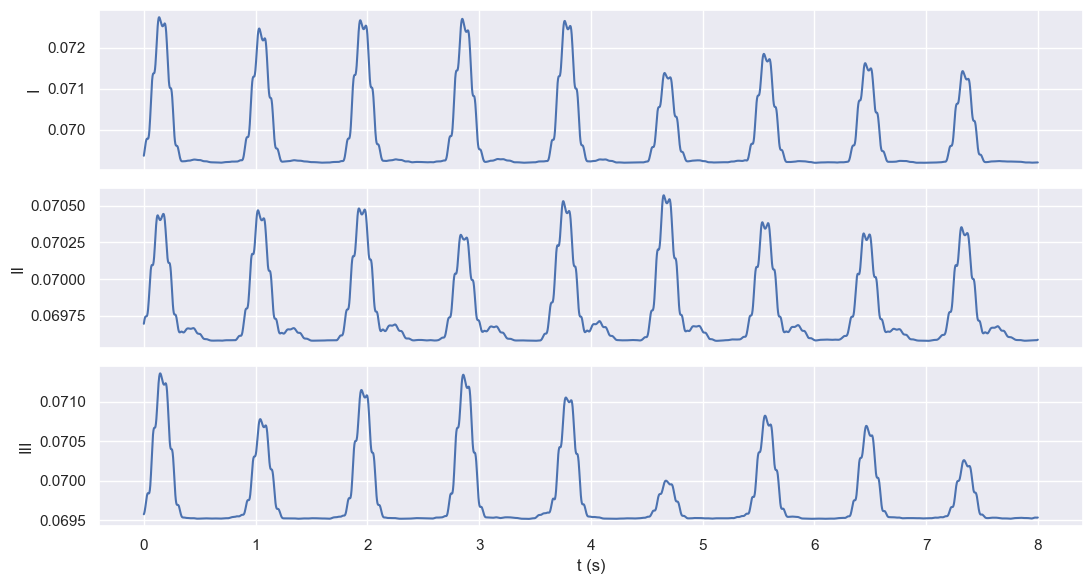

In [4]:
idx = np.random.randint(0, m)
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

In [5]:
build_features = BuildFeatures()

In [6]:
spect_entropy = build_features.spectral_entropy_ecg(ecg, fs)

c:\users\aleja\python\atrial_fibrillation_detection\afdetection\features\build_features.py:65: RuntimeWarning: divide by zero encountered in log2
  spectral_entropy = -np.sum(Pxx * np.log2(Pxx))
c:\users\aleja\python\atrial_fibrillation_detection\afdetection\features\build_features.py:65: RuntimeWarning: invalid value encountered in multiply
  spectral_entropy = -np.sum(Pxx * np.log2(Pxx))


In [23]:
ecg_features = pd.DataFrame(spect_entropy, columns=leads)
ecg_features = ecg_features.add_suffix('_spec_entropy')
display(ecg_features)

,I_spec_entropy,II_spec_entropy,III_spec_entropy,aVF_spec_entropy,aVR_spec_entropy,aVL_spec_entropy,V1_spec_entropy,V2_spec_entropy,V3_spec_entropy,V4_spec_entropy,V5_spec_entropy,V6_spec_entropy
0,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
1,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
2,2.506706,3.009748,4.409531,2.716170,2.436821,3.529405,2.677661,2.485850,2.547367,2.560969,2.608803,2.620466
3,1.148147,1.770946,2.465908,1.310650,1.089540,3.134664,0.855291,0.934886,1.486309,1.628305,1.023943,0.960868
4,3.612966,3.438919,3.890226,3.533026,3.717453,3.454853,3.560670,3.558945,3.536269,3.542047,3.571731,3.563359
...,...,...,...,...,...,...,...,...,...,...,...,...
6423,4.274991,4.221741,4.123835,4.312194,4.180064,4.145448,4.166901,4.100227,4.067787,4.075380,4.086429,4.111189
6424,3.773754,3.962813,3.920919,3.804665,3.799965,4.011297,3.935180,4.519224,4.243808,4.351523,3.767230,3.888101
6425,3.286940,3.899100,3.107284,3.880709,3.043798,3.279540,2.877888,2.852879,3.145880,2.951448,3.086531,3.104690
6426,4.338848,4.284936,4.225550,4.180253,4.124905,4.287628,4.201825,4.117103,4.095786,4.115953,4.148973,4.224494


In [24]:
data_DIR = path.data_raw_dir('ecg_features_spectral_entropy.csv')
ecg_features.to_csv(data_DIR, index=False)